In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Загрузка данных без заголовка через разделитель
df = pd.read_csv('classification_dataset.csv', header=None, sep=';')

#Узнаем сколько столбцов в датасете
print(f"Количество столбцов в DataFrame: {df.shape[1]}")

Количество столбцов в DataFrame: 15


In [261]:
#Именуем столбцы
column_names = ['A1', 'A2', 'A3', 'A4', 'A5',
                'A6', 'A7', 'A8', 'A9', 'A10',
                'A11', 'A12', 'A13', 'A14', 'A15']
continuous_columns = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']
categorical_columns = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']

df.columns = column_names

#Информация о данных в столбцах, вывод первых строк и подсчет значений целевой переменной
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    object 
 1   A2      690 non-null    float64
 2   A3      690 non-null    float64
 3   A4      690 non-null    int64  
 4   A5      690 non-null    int64  
 5   A6      690 non-null    int64  
 6   A7      690 non-null    float64
 7   A8      690 non-null    int64  
 8   A9      690 non-null    int64  
 9   A10     690 non-null    int64  
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    int64  
 13  A14     690 non-null    int64  
 14  A15     690 non-null    int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 81.0+ KB
None
  A1     A2     A3  A4  A5  A6     A7  A8  A9  A10  A11 A12  A13   A14  A15
0  b  22.08  11.46   2   4   4  1.585   0   0    0    1   g  100  1213    0
1  a  22.67   7.00   2   8   4  0.165   0   0

In [262]:
#Проверяем наличие пропусков
missing_values = df.isnull().sum()
print(missing_values)
#Пропуски не обнаружены

A1     0
A2     0
A3     0
A4     0
A5     0
A6     0
A7     0
A8     0
A9     0
A10    0
A11    0
A12    0
A13    0
A14    0
A15    0
dtype: int64


In [263]:
#Функция для вычисления границ экстремумов
def calculate_bounds(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = max(Q1 - 1.5 * IQR, column.min())
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

In [264]:
#Функция подсчета значений выходящий за экстремумы
def count_outliers(column, lower_bound, upper_bound):
    lower_count = ((column < lower_bound).sum())
    upper_count = ((column > upper_bound).sum())

    return lower_count, upper_count

Lower Bound: 13.75 Lower_count: 0

Upper Bound: 60.26 Upper_count: 18

A15
1    11
0     7
Name: count, dtype: int64
Boxplot for A2:


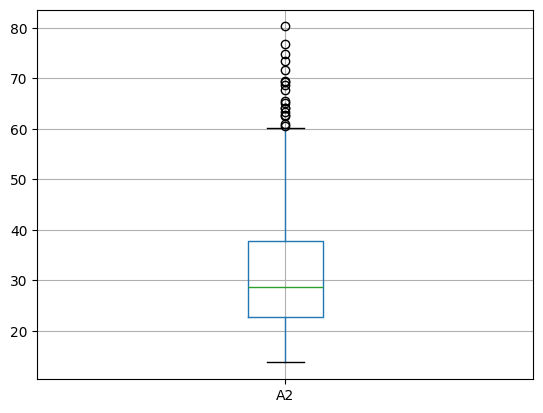

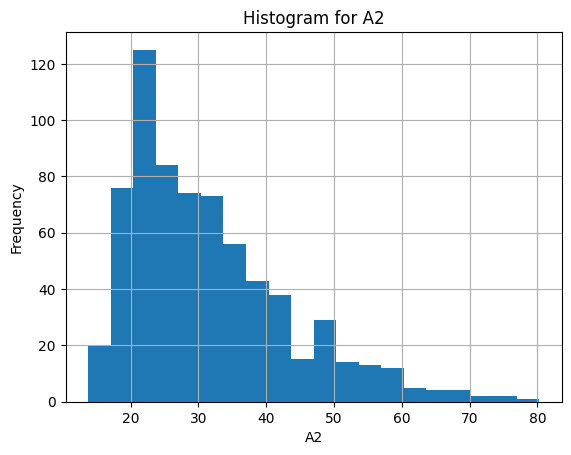

Lower Bound: 0.00 Lower_count: 0

Upper Bound: 16.52 Upper_count: 17

A15
1    12
0     5
Name: count, dtype: int64
Boxplot for A3:


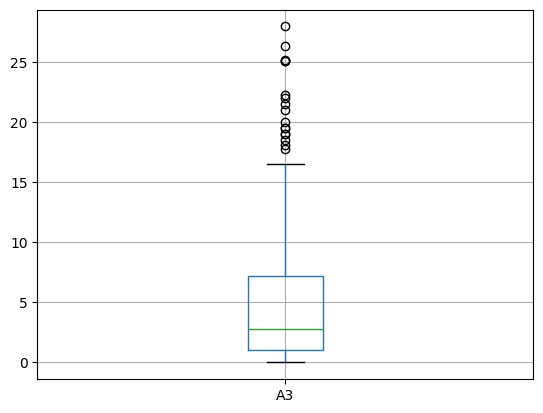

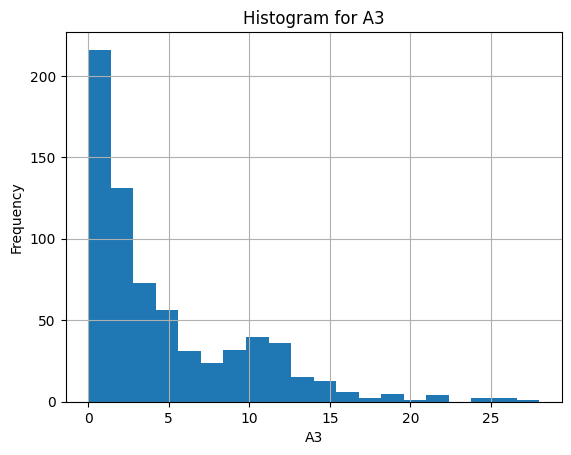

Lower Bound: 0.00 Lower_count: 0

Upper Bound: 6.31 Upper_count: 63

A15
1    48
0    15
Name: count, dtype: int64
Boxplot for A7:


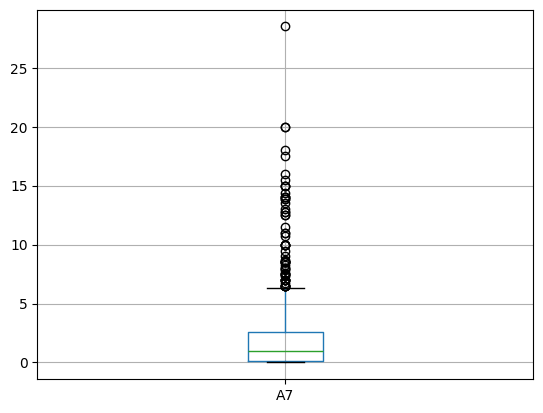

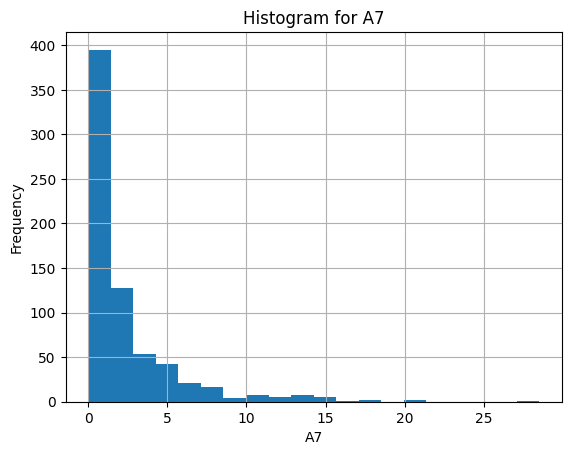

Lower Bound: 0.00 Lower_count: 0

Upper Bound: 7.50 Upper_count: 79

A15
1    72
0     7
Name: count, dtype: int64
Boxplot for A10:


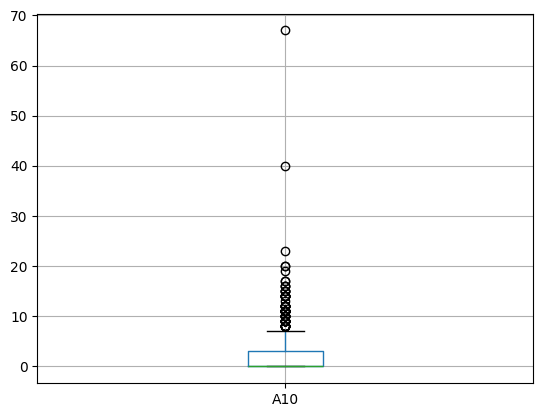

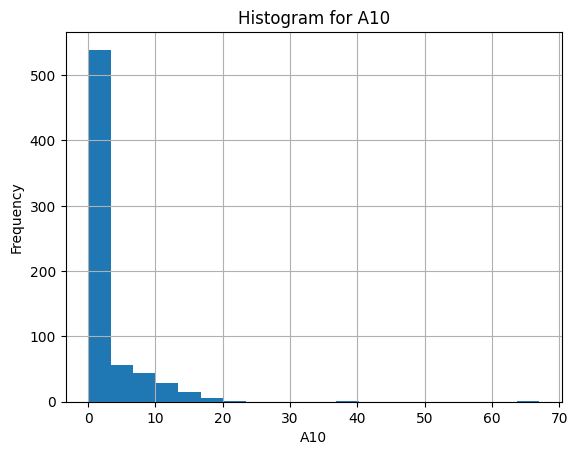

Lower Bound: 0.00 Lower_count: 0

Upper Bound: 560.00 Upper_count: 13

A15
0    10
1     3
Name: count, dtype: int64
Boxplot for A13:


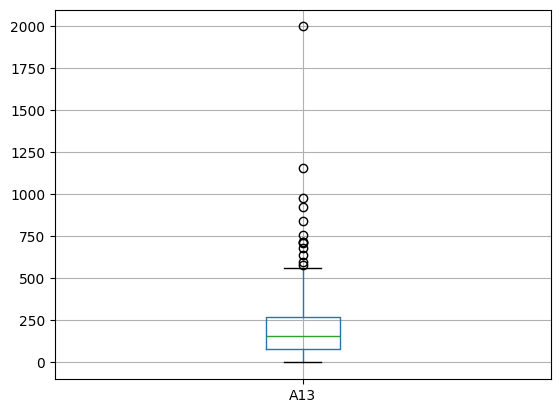

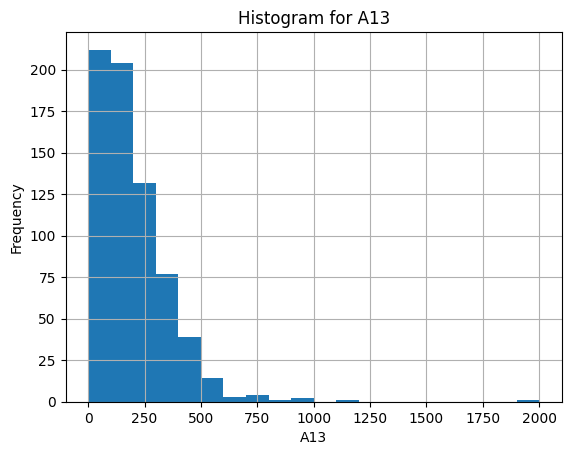

Lower Bound: 1.00 Lower_count: 0

Upper Bound: 989.75 Upper_count: 113

A15
1    89
0    24
Name: count, dtype: int64
Boxplot for A14:


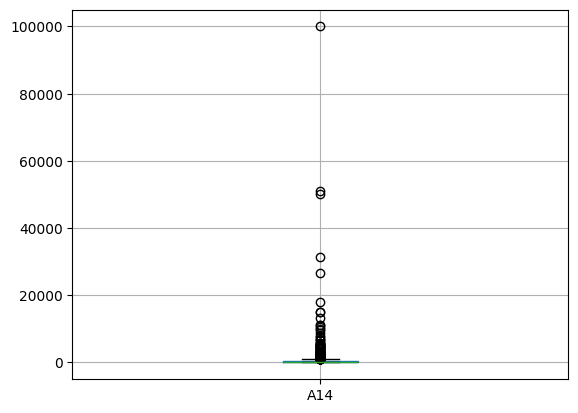

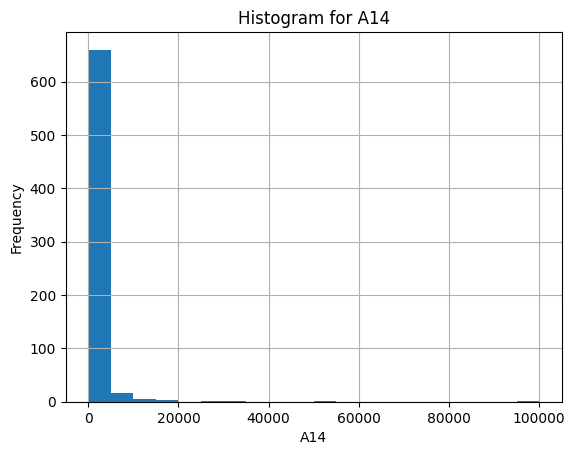

In [265]:
#Приводим информацию и стороим визиалузацию о выбросах и их значений на целевую переменную
continuous_columns = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14']

for col in continuous_columns:
   #Boxplot
    lower_bound, upper_bound = calculate_bounds(df[col])
    lower_count, upper_count = count_outliers(df[col], lower_bound, upper_bound)
    print(f"Lower Bound: {lower_bound:.2f} Lower_count: {lower_count}\n")
    print(f"Upper Bound: {upper_bound:.2f} Upper_count: {upper_count}\n")
    print((df['A15'][df[col] > upper_bound]).value_counts())
    print(f"Boxplot for {col}:")
    df.boxplot(column=col)
    plt.show()

    #Histogram
    df[col].hist(bins=20)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [266]:
#Нижних выбросов нет, верхние будут приведены к значению экстремумов
for col in continuous_columns:
   #Boxplot
    lower_bound, upper_bound = calculate_bounds(df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [267]:
#Для категориальных значений решено использовать использовать метод One-Hot Encoding
#с удалением первого значения для избежания мультиколлинеарности
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [268]:
#Подготовка выборки для обучения по методу Дерево Решений
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

X = df.drop('A15', axis = 1)
y = df['A15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (483, 34)
Размер тестовой выборки: (207, 34)


In [269]:
#Словарь значений гиперпараметров для Дерева Решений
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
# Создание модели Дерева решений
clf = DecisionTreeClassifier(random_state=325)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели на данных
grid_search.fit(X_train, y_train)

In [ ]:
#Выбор лучших гиперпараметров, оценка кроссвалидации
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

best_model = grid_search.best_estimator_

best_score = grid_search.best_score_
print(f"Лучшая точность на кросс-валидации: {best_score:.2f}")

In [ ]:
#Запуск модели на тестовой выборке, оценка точности
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {accuracy:.2f}")

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Экспорт дерева в формат DOT
dot_data = export_graphviz(best_model, out_file=None, 
                            feature_names=X.columns,  
                            class_names=['0', '1'],  
                            filled=True, rounded=True,  
                            special_characters=True)  

# Визуализация дерева
graph = graphviz.Source(dot_data)  
graph.render("decision_tree") 
graph.view() 

In [ ]:
#Подготовка выборки для обучения по методу K-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Подготовка данных
X = df.drop('A15', axis=1)
y = df['A15']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3258)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Сетка гиперпараметров
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Настройка GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Вывод лучших параметров и точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

In [ ]:
# Извлечение результатов кросс-валидации
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

# Создание словаря для хранения точности по числу соседей
scores_by_k = {}
for i, param in enumerate(params):
    k = param['n_neighbors']
    if k not in scores_by_k:
        scores_by_k[k] = []
    scores_by_k[k].append(mean_test_scores[i])

# Усреднение точности для каждого k
k_values = sorted(scores_by_k.keys())
avg_scores = [np.mean(scores_by_k[k]) for k in k_values]

# Построение графика зависимости точности от k
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость точности от числа соседей (k)')
plt.xlabel('Число соседей (k)')
plt.ylabel('Средняя точность (кросс-валидация)')
plt.grid(True)
plt.show()